# Notebook to obtain model performance

In this notebook, all the different models are trained and tested to obtain optimal selected features, hyperparameters and performance scores. The models to obtain the selected features and performance estimate are called from separate scripts. For all models, Recursive Feature Elimination with Cross Validation (to find the optimal number of features) is applied on the full dataset. With the selected features, the performance is estimated (using Nested CV). In addition to comparing the performance scores of the models trained, the scores are also compared to a benchmark model.

This notebook consists of three main sections:



Binary Classification <br>
The models to perform a binary classification with threshold of 30% damage are trained and tested. 

Multiclass Classification <br>
The models to perform multiclass classification with three classes are trained and tests.
- 0 - 30%
- 30% - 80%
- 80% - 100%

Regression <br>
The models to obtain a continous prediction are trained and tested.

## General Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle


## Local libraries

In [2]:
# Setting path to the initial folder
os.chdir("C:\\Users\\Marieke\\GitHub\\Typhoon_IBF_Rice_Damage_Model")
cdir = os.getcwd()
import importlib

# Binary classification functions
from IBF_typhoon_model.models.binary_classification.xgb_binary import xgb_binary_features, xgb_binary_performance
from IBF_typhoon_model.models.binary_classification.rf_binary import rf_binary_features, rf_binary_performance

# Multiclass classification functions
from IBF_typhoon_model.models.multiclass_classification.rf_multi import rf_multi_features, rf_multi_performance
from IBF_typhoon_model.models.multiclass_classification.xgb_multi import xgb_multi_features, xgb_multi_performance

# Regression functions
from IBF_typhoon_model.models.regression.rf_regression import rf_regression_features, rf_regression_performance
from IBF_typhoon_model.models.regression.xgb_regression import xgb_regression_features, xgb_regression_performance


# Utility functions
from IBF_typhoon_model.models.utility_functions.splitting_train_test import splitting_train_test
from IBF_typhoon_model.models.utility_functions.determine_class import determine_class
from IBF_typhoon_model.models.utility_functions.unweighted_random import unweighted_random
from IBF_typhoon_model.models.utility_functions.weighted_random import weighted_random

## Loading the Dataset

In [3]:
# Input data: the sheet that contains all the processed input data
name = "IBF_typhoon_model\\data\\restricted_data\\combined_input_data\\input_data_02.xlsx"
path = os.path.join(cdir, name)
df = pd.read_excel(path, engine="openpyxl")
display(df.head(5))

# Typhoon overview
file_name = "IBF_typhoon_model\\data\\restricted_data\\data_overview.xlsx"
path = os.path.join(cdir, file_name)
df_typh_overview = pd.read_excel(path, sheet_name="typhoon_overview", engine="openpyxl")
display(df_typh_overview.head(5))

,mun_code,typhoon,area_affected,storm_id,year,prov_code,rice_area,perc_loss,mean_slope,mean_elevation_m,...,with_coast,coast_length,perimeter,glat,glon,coast_peri_ratio,rainfall_sum,rainfall_max,vmax_sust,dis_track_min
0,PH140101000,goni2015,370.0,2015226N12151,2015,PH140100000,835.48,0.442859,7.17,171.58,...,0,0,81313,7.742,125.96,0.000000,618.4,218.8,25.252456,268.437280
1,PH140101000,haima2016,1520.0,2016288N07145,2016,PH140100000,1426.80,1.000000,15.86,919.58,...,0,0,99842,7.523,126.18,0.000000,267.2,130.8,95.558748,59.739518
2,PH140101000,koppu2015,310.0,2015285N14151,2015,PH140100000,1426.80,0.217269,5.38,182.68,...,0,0,119129,6.817,124.95,0.000000,328.4,140.0,70.616733,58.744205
3,PH140101000,mangkhut2018,1074.0,2018250N12170,2018,PH140100000,2223.88,0.482940,1.62,26.34,...,0,0,104831,7.152,124.52,0.000000,391.6,126.4,81.697745,65.696389
4,PH140101000,nanmadol2011,0.0,2011233N12129,2011,PH140100000,1235.80,0.000000,4.88,87.90,...,1,170,95705,7.893,123.73,0.001776,610.0,218.4,95.298929,185.140727


,pagasa_name,unofficial_name,year,unofficial_name_year,name_year,start_date,end_date,landfall_date,landfall_time,storm_id,Unnamed: 10
0,aere,Bebeng,2011,Bebeng2011,aere2011,2011-05-05,2011-05-15,2011-05-07,21:00:00,2011126N11129,NaN
1,atsani,siony,2020,siony2020,atsani2020,2020-10-29,2020-11-07,2020-11-06,00:00:00,2020304N08148,no landfall
2,bopha,pablo,2012,pablo2012,bopha2012,2012-11-25,2012-12-09,2012-12-03,21:00:00,2012331N03157,NaN
3,danas,falcon,2019,falcon2019,danas2019,2019-07-14,2019-07-23,2019-07-17,00:00:00,2019195N13136,no landfall in PH
4,durian,reming,2006,reming2006,durian2006,2006-11-24,2006-12-09,2006-11-30,06:00:00,2006329N06150,NaN


In [4]:
# Selecting the features to be used: should be available for historical and future typhoons
features = [
    "mean_slope",
    "mean_elevation_m",
    "ruggedness_stdev",
    "mean_ruggedness",
    "slope_stdev",
    "area_km2",
    "poverty_perc",
    "with_coast",
    "coast_length",
    "perimeter",
    "glat",
    "glon",
    "coast_peri_ratio",
    "rainfall_sum",
    "rainfall_max",
    "dis_track_min",
    "vmax_sust",
]

# Binary Classification

This section obtain the optimal Binary Classification models and the performance estimates, for a 30% threshold. Two models are implemented: Random Forest Classifier, XGBoost Classifier. First, the model is trained on the full dataset to obtain the optimal features followed by a model that obtains the performance estimate using Nested Cross Validation. 

- Performance Metric
- Nested Cross Validation
- Benchmark Models
- Main findings

In [5]:
# Setting the general input variables
threshold = 0.3
df["class_value_binary"] = [1 if df["perc_loss"][i] > threshold else 0 for i in range(len(df))]

# Setting for feature selection on full data set
X = df[features]
y = df['class_value_binary']
y = y.astype(int)

# Setting the train and the test sets for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(df)

## Random Forest

### Training the optimal model

In [ ]:
rf = RandomForestClassifier(
    class_weight="balanced",
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=3,
    min_samples_split=10,
)

selected_features_rf_binary = [
    "rice_area",
    "mean_elevation_m",
    "ruggedness_stdev",
    "mean_ruggedness",
    "slope_stdev",
    "area_km2",
    "poverty_perc",
    "perimeter",
    "glat",
    "glon",
    "coast_peri_ratio",
    "rainfall_sum",
    "rainfall_max",
    "dis_track_min",
    "vmax_sust",
]

rf_fitted = rf.fit(X[selected_features_rf_binary], y)

file_name = "IBF_typhoon_model\\models\\saved_models\\trained_binary_rf.sav"
path = os.path.join(cdir, file_name)
pickle.dump(rf_fitted, open(path, "wb"))

C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


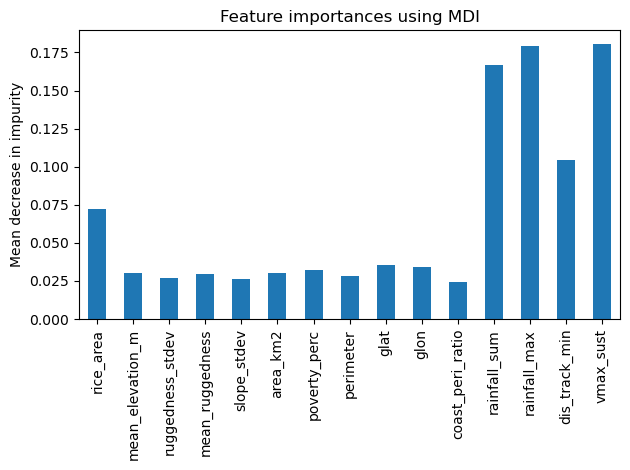

In [8]:
# Display feature importance
importances = rf_fitted.feature_importances_
forest_importances = pd.Series(importances, index=selected_features_rf_binary)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

### Obtain features and optimal hyperparameters

Number of selected features RF Binary: 15

Selected features RF Binary:
- rice_area
- mean_elevation_m
- ruggedness_stdev
- mean_ruggedness
- slope_stdev
- area_km2
- poverty_perc
- perimeter
- glat
- glon
- coast_peri_ratio
- rainfall_sum
- rainfall_max
- dis_track_min
- vmax_sust


Selected parameters RF Binary:
- max_depth = None
- min_samples_leaf = 3
- min_samples_split = 10
- n_estimators = 100

In [6]:
# Setting the random forest search grid
rf_search_space = [
    {
        "estimator__n_estimators": [50, 100, 500],
        "estimator__max_depth": [20, None],
        "estimator__min_samples_split": [2, 8, 10],
        "estimator__min_samples_leaf": [1, 3, 5],
    }
]

# Obtaining the selected features based on the full dataset
selected_features_rf_binary, selected_params_rf_binary_full = rf_binary_features(
    X=X,
    y=y,
    features=features,
    search_space=rf_search_space,
    cv_splits=5,
    class_weight="balanced",
    min_features_to_select=1,
    GS_score="f1",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

print(f"Number of selected features RF Binary: {len(selected_features_rf_binary)}")
print(f"Selected features RF Binary: {selected_features_rf_binary}")
print(f"Selected Parameters RF Binary {selected_params_rf_binary_full}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 1/5; 1/54] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=0.998, test=0.559) total time=  27.0s
[CV 2/5; 1/54] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 2/5; 1/54] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=0.999, test=0.603) total time=  24.4s
[CV 3/5; 1/54] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 3/5; 1/54] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=0.997, 

### Obtaining performance estimate

In [7]:
# Setting the selected features for RF --> based on outcome in previous cell
selected_features_rf_binary = [
    "rice_area",
    "mean_slope",
    "mean_elevation_m",
    "ruggedness_stdev",
    "mean_ruggedness",
    "slope_stdev",
    "area_km2",
    "poverty_perc",
    "with_coast",
    "coast_length",
    "perimeter",
    "glat",
    "glon",
    "coast_peri_ratio",
    "rainfall_sum",
    "rainfall_max",
    "dis_track_min",
    "vmax_sust",
]


In [9]:
# Setting the random forest search grid
rf_search_space = [
    {
        "rf__n_estimators": [50, 100, 500],
        "rf__max_depth": [20, None],
        "rf__min_samples_split": [2, 8, 10],
        "rf__min_samples_leaf": [1, 3, 5],
    }
]

# Obtaining the performance estimate
df_predicted_rf_binary, selected_params_rf_binary = rf_binary_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    features=selected_features_rf_binary,
    search_space=rf_search_space,
    stratK=True,
    cv_splits=5,
    class_weight="balanced",
    GS_score="f1",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)


Running for 1 out of a total of 5
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 1/5; 1/54] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=0.999, test=0.529) total time=   0.3s
[CV 2/5; 1/54] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 2/5; 1/54] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=0.997, test=0.511) total time=   0.3s
[CV 3/5; 1/54] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 3/5; 1/54] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=0.996, test=0.561) total time=   0.3s
[CV 4/5; 1/54] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimator

In [24]:
file_name = "IBF_typhoon_model\\models\\output\\selected_params_rf_binary.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_rf_binary, open(path, "wb"))

file_name = "IBF_typhoon_model\\models\\output\\df_predicted_rf_binary.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_binary.to_csv(path, index=False)


## XGBoost

### Obtaining optimal features and hyperparamters

Number of selected features XGGBoost Binary: 

Selected features XGBoost Binary:


Selected parameters XGBoost Binary:


In [32]:
# Setting the XGBoost search grid for full dataset
xgb_search_space = [
    {
        "estimator__learning_rate": [0.1, 0.5, 1],
        "estimator__gamma": [0.1, 0.5, 2],
        "estimator__max_depth": [6, 8],
        "estimator__reg_lambda": [0.001, 0.01, 0.1, 1],
        "estimator__n_estimators": [100, 200],
        "estimator__colsample_bytree": [0.5, 0.7, 1],
    }
]

# Obtaining the selected features based on the full dataset
selected_features_xgb_binary, selected_params_xgb_binary_full = xgb_binary_features(
    X=X,
    y=y,
    features=features,
    search_space=xgb_search_space,
    objective="binary:hinge",
    cv_splits=5,
    min_features_to_select=1,
    GS_score="f1",
    GS_n_iter=1,
    GS_randomized=False,
    verbose=10,
)

print(f"Number of selected features XGBoost Binary {len(selected_features_xgb_binary)}")
print(f"Selected features XGBoost Binary: {selected_features_xgb_binary}")
print(f"Selected parameters XGBoost Binary: {selected_params_xgb_binary_full}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5; 1/432] START estimator__colsample_bytree=0.5, estimator__gamma=0.1, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__n_estimators=100, estimator__reg_lambda=0.001
[CV 1/5; 1/432] END estimator__colsample_bytree=0.5, estimator__gamma=0.1, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__n_estimators=100, estimator__reg_lambda=0.001;, score=(train=0.667, test=0.543) total time=  42.1s
[CV 2/5; 1/432] START estimator__colsample_bytree=0.5, estimator__gamma=0.1, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__n_estimators=100, estimator__reg_lambda=0.001
[CV 2/5; 1/432] END estimator__colsample_bytree=0.5, estimator__gamma=0.1, estimator__learning_rate=0.1, estimator__max_depth=6, estimator__n_estimators=100, estimator__reg_lambda=0.001;, score=(train=0.663, test=0.556) total time=  47.9s
[CV 3/5; 1/432] START estimator__colsample_bytree=0.5, estimator__gamma=0.1, estim

### Obtaining performance estimate

In [ ]:
# Setting the selected features for XGB --> based on outcome previous cell
selected_features_xgb_binary = [
    'rice_area', 
    'mean_slope', 
    'mean_elevation_m', 
    'ruggedness_stdev', 
    'mean_ruggedness', 
    'slope_stdev', 
    'area_km2', 
    'poverty_perc', 
    'with_coast', 
    'coast_length', 
    'perimeter', 
    'glat', 
    'glon', 
    'coast_peri_ratio', 
    'rainfall_sum', 
    'rainfall_max', 
    'dis_track_min', 
    'vmax_sust'
]

In [11]:
# Setting the XGBoost search grid
xgb_search_space = [
    {
        "xgb__learning_rate": [0.1, 0.3],
        "xgb__gamma": [0.1, 0.5, 2],
        "xgb__max_depth": [6, 8],
        "xgb__reg_lambda": [0.01, 0.1, 1],
        "xgb__n_estimators": [100, 150],
        "xgb__colsample_bytree": [0.5, 0.7],
    }
]

# Obtaining the performance estimate
df_predicted_xgb_binary, selected_params_xgb_binary = xgb_binary_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    features=selected_features_xgb_binary,
    search_space=xgb_search_space,
    stratK=True,
    cv_splits=5,
    objective="binary:hinge",
    GS_score="f1",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)


Running for 1 out of a total of 5
Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START xgb__colsample_bytree=0.5, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100, xgb__reg_lambda=0.01
[CV 1/5; 1/144] END xgb__colsample_bytree=0.5, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100, xgb__reg_lambda=0.01;, score=(train=0.762, test=0.587) total time=   0.3s
[CV 2/5; 1/144] START xgb__colsample_bytree=0.5, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100, xgb__reg_lambda=0.01
[CV 2/5; 1/144] END xgb__colsample_bytree=0.5, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100, xgb__reg_lambda=0.01;, score=(train=0.782, test=0.555) total time=   0.4s
[CV 3/5; 1/144] START xgb__colsample_bytree=0.5, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100, xgb__reg_lambda=0.01
[CV 3/5; 1/144] END xgb__colsample_bytree=0.5,

In [ ]:
file_name = "IBF_typhoon_model\\models\\output\\selected_params_xgb_binary.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_xgb_binary, open(path, "wb"))

file_name = "IBF_typhoon_model\\models\\output\\df_predicted_xgb_binary.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_binary.to_csv(path, index=False)


## Benchmark

In [50]:
# Random unweighted predictions
df_predicted_random = pd.DataFrame(columns=["year", "actual", "predicted"])

for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    y_train = train["class_value_binary"]
    y_test = test["class_value_binary"]

    y_pred_test = unweighted_random(y_train, y_test)
    df_predicted_temp = pd.DataFrame(
        {"year": test["year"], "actual": y_test, "predicted": y_pred_test}
    )

    df_predicted_random = pd.concat([df_predicted_random, df_predicted_temp])



C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.30560271646859083
0.21765417170495768
0.5128205128205128


In [45]:
# Random Weighted Predictions
df_predicted_random_weighted = pd.DataFrame(columns=["year", "actual", "predicted"])
for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    y_train = train["class_value_binary"]
    y_test = test["class_value_binary"]

    y_pred_test = weighted_random(y_train, y_test)
    df_predicted_temp = pd.DataFrame(
        {"year": test["year"], "actual": y_test, "predicted": y_pred_test}
    )

    df_predicted_random_weighted = pd.concat(
        [df_predicted_random_weighted, df_predicted_temp]
    )



C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.22002472187886282


## Results

In [ ]:
models = {
    "Random Fores": df_predicted_rf_binary,
    "XGBoost": df_predicted_xgb_binary,
    "Random": df_predicted_random,
    "Weighted Random": df_predicted_random_weighted,
}

f1 = []
precision = []
recall = []

# add 'list' if error
for df in models.values():
    f1.append(f1_score(df["actual"], df["predicted"]))
    precision.append(precision_score(df["actual"], df["predicted"]))
    recall.append(recall_score(df["actual"], df["predicted"]))

df_results_binary = pd.DataFrame(
    {"Models": models.keys(), "F1 score": f1, "Recall": recall, "Precision": precision}
)

display(df_results_binary)



# Multiclass Classification

This section obtains the optimal Multiclass Classification models and the performance estimates, with three classes. Two models are implemented: Random Forest Classifier, XGBoost Classifier. First, the model is trained on the full dataset to obtain the optimal features followed by a model that obtains the performance estimate using Nested Cross Validation. The classes are:
- 0 - 30%
- 30% - 80%
- 80% - 100% <br> <br>


- Performance Metric
- Nested Cross Validation
- Benchmark Models
- Main findings

In [46]:
# Setting class value
# Set final boundary slightly over 1 so 1's are included as well
classes = {"0": [0, 0.3], "1": [0.3, 0.8], "2": [0.8, 1.1]}
df['class_value_multi'] = df['perc_loss'].apply(lambda x: determine_class(x, classes=classes))

# Setting for feature seleciton on full data set
X = df[features]
y = df['class_value_multi']

# Setting train and test set for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(df)

C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Random Forest

### Selecting the optimal hyperparameters and features

Number of features selected in RF multiclass: 12

The selected features ares:
- rice_area
- mean_elevation_m
- mean_ruggedness
- area_km2
- poverty_perc
- perimeter
- glat
- glon
- rainfall_sum
- rainfall_max
- dis_track_min

Selected Parameters in RF multiclass: 
- max_depth = 20
- min_samples_leaf = 5
- min_samples_split = 10
- n_estimators = 50

In [11]:
# Setting the random forest search grid
rf_search_space = [
    {
        "estimator__n_estimators": [50, 100],
        "estimator__max_depth": [20, None],
        "estimator__min_samples_split": [2, 8, 10],
        "estimator__min_samples_leaf": [1, 3, 5],
    }
]

selected_features_rf_multi, selected_params_rf_multi_full = rf_multi_features(
    X=X,
    y=y,
    features=features,
    search_space=rf_search_space,
    cv_splits=5,
    class_weight="balanced",
    min_features_to_select=1,
    GS_score="f1_macro",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

print(
    f"Number of features selected in RF multiclass: {len(selected_features_rf_multi)}"
)
print(f"Selected features RF multiclass: {selected_features_rf_multi}")
print(f"Selected Parameters in RF multiclass: {selected_params_rf_multi_full}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 1/5; 1/36] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=1.000, test=0.496) total time=  28.3s
[CV 2/5; 1/36] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 2/5; 1/36] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=1.000, test=0.477) total time=  24.0s
[CV 3/5; 1/36] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 3/5; 1/36] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=0.999, 

### Obtaining the performance estimate

In [ ]:
# Setting the selected features for RF --> based on output previous cell
selected_features_rf_multi = [
    "rice_area",
    "mean_slope",
    "mean_elevation_m",
    "ruggedness_stdev",
    "mean_ruggedness",
    "slope_stdev",
    "area_km2",
    "poverty_perc",
    "with_coast",
    "coast_length",
    "perimeter",
    "glat",
    "glon",
    "coast_peri_ratio",
    "rainfall_sum",
    "rainfall_max",
    "dis_track_min",
    "vmax_sust",
]


In [13]:
# Obtain the performance estimate
rf_search_space = [
    {
        "rf__n_estimators": [50, 100],
        "rf__max_depth": [20, None],
        "rf__min_samples_split": [2, 8, 10],
        "rf__min_samples_leaf": [1, 3, 5],
    }
]

df_predicted_rf_multi, selected_params_rf_multi = rf_multi_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    features=selected_features_rf_multi,
    search_space=rf_search_space,
    stratK=True,
    cv_splits=5,
    class_weight="balanced",
    GS_score="f1_macro",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)



C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running for 1 out of a total of 5
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 1/5; 1/36] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=1.000, test=0.499) total time=   0.3s
[CV 2/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 2/5; 1/36] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=0.999, test=0.479) total time=   0.3s
[CV 3/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 3/5; 1/36] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=0.999, test=0.472) total time=   0.3s
[CV 4/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimator

C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\Marieke\\GitHub\\Typhoon_IBF_Rice_Damage_Model\\IBF_typhoon_model\\models\\output\\selected_params_rf_multi.p'>


In [ ]:
#Saving the results
file_name = "IBF_typhoon_model\\models\\output\\selected_params_rf_multi.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_rf_multi, open(path, "wb"))

file_name = "IBF_typhoon_model\\models\\output\\df_predicted_rf_multi.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_multi.to_csv(path)


## XGBoost

### Obtaining the optimal features and hyperparameters

Number of selected features:

Selected features:

Selected hyperparameters:

In [ ]:
# Setting the XGBoost search grid
xgb_search_space = [
    {
        "estimator__learning_rate": [0.1, 0.5, 1],
        "estimator__gamma": [0.1, 0.5, 2],
        "estimator__max_depth": [6, 8],
        "estimator__reg_lambda": [0.001, 0.01, 0.1, 1],
        "estimator__n_estimators": [100, 200],
        "estimator__colsample_bytree": [0.5, 0.7, 1],
    }
]

selected_features_xgb_multi, selected_params_xgb_multi_full = xgb_multi_features(
    X=X,
    y=y,
    features=features,
    num_class=len(classes),
    search_space=xgb_search_space,
    objective="multi:softmax",
    cv_splits=5,
    min_features_to_select=7,
    GS_score="f1_macro",
    GS_randomized=True,
    GS_n_iter=10,
    verbose=10,
)

print(
    f"Number of features selected in RF multiclass: {len(selected_features_xgb_multi)}"
)
print(f"Selected features RF multiclass: {selected_features_xgb_multi}")
print(f"Selected Parameters in RF multiclass: {selected_params_xgb_multi_full}")


### Obtaining model performance

In [ ]:
# Setting the selected features for XGB
selected_features_xgb_multi = [
    "rice_area",
    "mean_slope",
    "mean_elevation_m",
    "ruggedness_stdev",
    "mean_ruggedness",
    "slope_stdev",
    "area_km2",
    "poverty_perc",
    "with_coast",
    "coast_length",
    "perimeter",
    "glat",
    "glon",
    "coast_peri_ratio",
    "rainfall_sum",
    "rainfall_max",
    "dis_track_min",
    "vmax_sust",
]


In [ ]:
# Setting the XGBoost search grid
xgb_search_space = [
    {
        "xgb__learning_rate": [0.1, 0.5, 1],
        "xgb__gamma": [0.1, 0.5, 2],
        "xgb__max_depth": [6, 8],
        "xgb__reg_lambda": [0.001, 0.01, 0.1, 1],
        "xgb__n_estimators": [100, 200],
        "xgb__colsample_bytree": [0.5, 0.7, 1],
    }
]

df_predicted_xgb_multi, selected_params_xgb_multi = xgb_multi_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    num_class=len(classes),
    features=selected_features_xgb_multi,
    search_space=xgb_search_space,
    stratK=True,
    cv_splits=5,
    objective="multi:softmax",
    GS_score="f1_macro",
    GS_randomized=True,
    GS_n_iter=10,
    verbose=10,
)


In [ ]:
# Saving the results
file_name = "IBF_typhoon_model\\models\\output\\selected_params_xgb_multi.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_xgb_multi, open(path, "wb"))

file_name = "IBF_typhoon_model\\models\\output\\df_predicted_xgb_multi.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_multi.to_csv(path)


## Benchmark

In [47]:
# Random unweighted predictions
df_predicted_random_multi = pd.DataFrame(columns=["year", "actual", "predicted"])

for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    y_train = train["class_value_multi"]
    y_test = test["class_value_multi"]

    y_pred_test = unweighted_random(y_train, y_test)
    df_predicted_temp = pd.DataFrame(
        {"year": test["year"], "actual": y_test, "predicted": y_pred_test}
    )

    df_predicted_random_multi = pd.concat(
        [df_predicted_random_multi, df_predicted_temp]
    )


0.26460962731928306


C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Random Weighted Predictions
df_predicted_random_weighted_multi = pd.DataFrame(
    columns=["year", "actual", "predicted"]
)
for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    y_train = train["class_value_multi"]
    y_test = test["class_value_multi"]

    y_pred_test = weighted_random(y_train, y_test)
    df_predicted_temp = pd.DataFrame(
        {"year": test["year"], "actual": y_test, "predicted": y_pred_test}
    )

    df_predicted_random_weighted_multi = pd.concat(
        [df_predicted_random_weighted_multi, df_predicted_temp]
    )



## Results

In [135]:
models = {
    "Random Fores": df_predicted_rf_multi,
    "XGBoost": df_predicted_xgb_multi,
    "Random": df_predicted_random_multi,
    "Weighted Random": df_predicted_random_weighted_multi,
}

f1 = []
precision = []
recall = []

# add 'list' if error
for df in models.values():
    f1.append(f1_score(df["actual"], df["predicted"], average="macro"))
    precision.append(precision_score(df["actual"], df["predicted"], average="macro"))
    recall.append(recall_score(df["actual"], df["predicted"], average="macro"))

df_results_binary = pd.DataFrame(
    {"Models": models.keys(), "F1 score": f1, "Recall": recall, "Precision": precision}
)

display(df_results_binary)


<IPython.core.display.Javascript object>

# Regression

This sections contains the Regression models that are trained and tested to obtain the optimal model, hyperparameter settings and features. First the model is trained on the full dataset to obtain the optimal features followed by a model that obtains the performance estimate using Nested Cross Validation.


- Performance metrics
- Nested Cross Validation
- Benchmark Models
- Main finding

In [27]:
# Full dataset for feature selection
X = df[features]
y = df['perc_loss']

# Setting the train and the test sets for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(df)

C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Random Forest

### Training the optimal model

Number of selected features RF Regression: 12

Selected features RF Regression:
- rice_area
- mean_elevation_m
- mean_ruggedness
- poverty_perc
- perimeter
- glat
- glon
- coast_peri_ratio
- rainfall_sum
- rainfall_max
- dis_track_min
- vmax_sust


Selected Parameters RF Regression: 
- max_depth = None
- min_samples_leaf = 3
- min_samples_split = 8
- n_estimators = 100

In [7]:
#%% Setting input varialbes
rf_search_space = [
    {
        "estimator__n_estimators": [50, 100],
        "estimator__max_depth": [20, None],
        "estimator__min_samples_split": [2, 8, 10],
        "estimator__min_samples_leaf": [1, 3, 5],
    }
]

(
    selected_features_rf_regr,
    selected_params_rf_regr_full,
) = rf_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=rf_search_space,
    min_features_to_select=1,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

print(
    f"Number of selected features RF Regression {len(selected_features_rf_regr)}"
)
print(f"Selected features RF Regression: {selected_features_rf_regr}")
print(f"Selected Parameters RF Regression: {selected_params_rf_regr_full}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 1/5; 1/36] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=-0.100, test=-0.252) total time= 1.7min
[CV 2/5; 1/36] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 2/5; 1/36] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=-0.100, test=-0.263) total time= 1.5min
[CV 3/5; 1/36] START estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50
[CV 3/5; 1/36] END estimator__max_depth=20, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50;, score=(train=-0.

### Obtaining the performance estimate

In [ ]:
# Based on output previous cell
selected_features_rf_regr = [
    "rice_area",
    "mean_slope",
    "mean_elevation_m",
    "ruggedness_stdev",
    "mean_ruggedness",
    "slope_stdev",
    "area_km2",
    "poverty_perc",
    "with_coast",
    "coast_length",
    "perimeter",
    "glat",
    "glon",
    "coast_peri_ratio",
    "rainfall_sum",
    "rainfall_max",
    "dis_track_min",
    "vmax_sust",
]


In [35]:
#%% Setting input varialbes
rf_search_space = [
    {
        "rf__n_estimators": [50, 100],
        "rf__max_depth": [20, None],
        "rf__min_samples_split": [2, 8, 10],
        "rf__min_samples_leaf": [1, 3, 5],
    }
]

df_predicted_rf_regr, selected_params_rf_regr = rf_regression_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    features=selected_features_rf_regr,
    search_space=rf_search_space,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)


Running for 1 out of a total of 5
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 1/5; 1/36] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=-0.099, test=-0.247) total time=   1.5s
[CV 2/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 2/5; 1/36] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=-0.097, test=-0.268) total time=   1.6s
[CV 3/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50
[CV 3/5; 1/36] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50;, score=(train=-0.098, test=-0.257) total time=   1.4s
[CV 4/5; 1/36] START rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_est

C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel_launcher.py:22: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\Marieke\\GitHub\\Typhoon_IBF_Rice_Damage_Model\\IBF_typhoon_model\\models\\output\\selected_params_rf_regression.p'>


In [36]:
file_name = "IBF_typhoon_model\\models\\output\\selected_params_rf_regr.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_rf_regr, open(path, "wb"))

file_name = "IBF_typhoon_model\\models\\output\\df_predicted_rf_regr.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_regr.to_csv(path)


C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,year,actual,predicted
1,2016,1.000000,0.388299
10,2016,0.487939,0.394629
19,2016,1.000000,0.557920
24,2016,1.000000,0.435221
37,2016,0.667525,0.423134


## XGBoost Regression

### Obtaining the optimal model

In [ ]:
xgb_search_space = [
    {
        "estimator__learning_rate": [0.1, 0.5, 1],
        "estimator__gamma": [0.1, 0.5, 2],
        "estimator__max_depth": [6, 8],
        "estimator__reg_lambda": [0.001, 0.01, 0.1, 1],
        "estimator__n_estimators": [100, 200],
        "estimator__colsample_bytree": [0.5, 0.7, 1],
    }
]

selected_features_xgb_regr, selected_params_xgb_regr_full = xgb_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=xgb_search_space,
    min_features_to_select=7,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    objective='"reg:squarederror"',
    GS_randomized=True,
    GS_n_iter=10,
    verbose=10,
)


print(f"Number of selected features XGBoost Regression {len(selected_features_xgb_regr)}")
print(f"Selected features XGBoost Regression: {selected_features_xgb_regr}")
print(f"Selected Parameters XGBoost Regression: {selected_params_xgb_regr_full}")



### Obtaining the performance estimate

In [ ]:
# Setting the selected features for XGB
selected_features_xgb_regr = [
    'rice_area', 
    'mean_slope', 
    'mean_elevation_m', 
    'ruggedness_stdev', 
    'mean_ruggedness', 
    'slope_stdev', 
    'area_km2', 
    'poverty_perc', 
    'with_coast', 
    'coast_length', 
    'perimeter', 
    'glat', 
    'glon', 
    'coast_peri_ratio', 
    'rainfall_sum', 
    'rainfall_max', 
    'dis_track_min', 
    'vmax_sust'
]

In [ ]:
xgb_search_space = [
    {
        "xgb__learning_rate": [0.1, 0.5, 1],
        "xgb__gamma": [0.1, 0.5, 2],
        "xgb__max_depth": [6, 8],
        "xgb__reg_lambda": [0.001, 0.01, 0.1, 1],
        "xgb__n_estimators": [100, 200],
        "xgb__colsample_bytree": [0.5, 0.7, 1],
    }
]

df_predicted_xgb_regr, selected_params_xgb_regr = xgb_regression_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    features=features,
    search_space=xgb_search_space,
    cv_splits=5,
    objective="reg:squarederror",
    GS_score="neg_root_mean_squared_error",
    GS_randomized=True,
    GS_n_iter=10,
    verbose=10,
)


In [ ]:
file_name = "IBF_typhoon_model\\models\\output\\selected_params_xgb_regr.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_xgb_regr, open(path, "wb"))

file_name = "IBF_typhoon_model\\models\\output\\df_predicted_xgb_regr.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_regr.to_csv(path)


## Benchmark

## Results